In [ ]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
import torch.nn as nn
import torch.optim as optim
import math
import torch.nn.functional as F
from torch.cuda.amp import GradScaler, autocast
import numpy as np
import time
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



batch_size = 256
img_height, img_width = 224, 224
epochs = 40
num_classes = 22 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


transforms = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load datasets
test_dataset = datasets.ImageFolder('/kaggle/input/pest-data/Testing_Data', transform=transforms)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [2]:
# Define the KANLinear class
class KANLinear(nn.Module):
    def __init__(
        self,
        in_features,
        out_features,
        grid_size=10,
        spline_order=4,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        enable_standalone_scale_spline=True,
        base_activation=nn.ReLU,
        grid_eps=0.01,
        grid_range=[-1, 1],
    ):
        super(KANLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order

        h = (grid_range[1] - grid_range[0]) / grid_size
        grid = (
            (
                torch.arange(-spline_order, grid_size + spline_order + 1) * h
                + grid_range[0]
            )
            .expand(in_features, -1)
            .contiguous()
        )
        self.register_buffer("grid", grid)

        self.base_weight = nn.Parameter(torch.Tensor(out_features, in_features))
        self.spline_weight = nn.Parameter(
            torch.Tensor(out_features, in_features, grid_size + spline_order)
        )
        if enable_standalone_scale_spline:
            self.spline_scaler = nn.Parameter(
                torch.Tensor(out_features, in_features)
            )

        self.scale_noise = scale_noise
        self.scale_base = scale_base
        self.scale_spline = scale_spline
        self.enable_standalone_scale_spline = enable_standalone_scale_spline
        self.base_activation = base_activation()
        self.grid_eps = grid_eps

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5) * self.scale_base)
        with torch.no_grad():
            noise = (
                (
                    torch.rand(self.grid_size + 1, self.in_features, self.out_features)
                    - 1 / 2
                )
                * self.scale_noise
                / self.grid_size
            )
            self.spline_weight.data.copy_(
                (self.scale_spline if not self.enable_standalone_scale_spline else 1.0)
                * self.curve2coeff(
                    self.grid.T[self.spline_order : -self.spline_order],
                    noise,
                )
            )
            if self.enable_standalone_scale_spline:
                nn.init.kaiming_uniform_(self.spline_scaler, a=math.sqrt(5) * self.scale_spline)

    def b_splines(self, x: torch.Tensor):
        """
        Compute the B-spline bases for the given input tensor.
        """
        assert x.dim() == 2 and x.size(1) == self.in_features

        grid: torch.Tensor = self.grid
        x = x.unsqueeze(-1)
        bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)
        for k in range(1, self.spline_order + 1):
            bases = (
                (x - grid[:, : -(k + 1)])
                / (grid[:, k:-1] - grid[:, : -(k + 1)])
                * bases[:, :, :-1]
            ) + (
                (grid[:, k + 1 :] - x)
                / (grid[:, k + 1 :] - grid[:, 1:(-k)])
                * bases[:, :, 1:]
            )

        return bases.contiguous()

    def curve2coeff(self, x: torch.Tensor, y: torch.Tensor):
        """
        Compute the coefficients of the curve that interpolates the given points.
        """
        assert x.dim() == 2 and x.size(1) == self.in_features
        assert y.size() == (x.size(0), self.in_features, self.out_features)

        A = self.b_splines(x).transpose(0, 1)  # (in_features, batch_size, grid_size + spline_order)
        B = y.transpose(0, 1)  # (in_features, batch_size, out_features)
        solution = torch.linalg.lstsq(A, B).solution  # (in_features, grid_size + spline_order, out_features)
        result = solution.permute(2, 0, 1)  # (out_features, in_features, grid_size + spline_order)

        return result.contiguous()

    @property
    def scaled_spline_weight(self):
        return self.spline_weight * (
            self.spline_scaler.unsqueeze(-1)
            if self.enable_standalone_scale_spline
            else 1.0
        )

    def forward(self, x: torch.Tensor):
        x = x.to(self.grid.device)  # Move x to the same device as grid
        assert x.size(-1) == self.in_features
        original_shape = x.shape
        x = x.view(-1, self.in_features)

        base_output = F.linear(self.base_activation(x), self.base_weight)
        spline_output = F.linear(
            self.b_splines(x).view(x.size(0), -1),
            self.scaled_spline_weight.view(self.out_features, -1),
        )
        output = base_output + spline_output
    
        output = output.view(*original_shape[:-1], self.out_features)
        return output

    @torch.no_grad()
    def update_grid(self, x: torch.Tensor, margin=0.01):
        assert x.dim() == 2 and x.size(1) == self.in_features
        batch = x.size(0)

        splines = self.b_splines(x)  # (batch, in, coeff)
        splines = splines.permute(1, 0, 2)  # (in, batch, coeff)
        orig_coeff = self.scaled_spline_weight  # (out, in, coeff)
        orig_coeff = orig_coeff.permute(1, 2, 0)  # (in, coeff, out)
        unreduced_spline_output = torch.bmm(splines, orig_coeff)  # (in, batch, out)
        unreduced_spline_output = unreduced_spline_output.permute(1, 0, 2)  # (batch, in, out)

        x_sorted = torch.sort(x, dim=0)[0]
        grid_adaptive = x_sorted[
            torch.linspace(
                0, batch - 1, self.grid_size + 1, dtype=torch.int64, device=x.device
            )
        ]

        uniform_step = (x_sorted[-1] - x_sorted[0] + 2 * margin) / self.grid_size
        grid_uniform = (
            torch.arange(
                self.grid_size + 1, dtype=torch.float32, device=x.device
            ).unsqueeze(1)
            * uniform_step
            + x_sorted[0]
            - margin
        )

        grid = self.grid_eps * grid_uniform + (1 - self.grid_eps) * grid_adaptive
        grid = torch.cat(
            [
                grid[:1]
                - uniform_step
                * torch.arange(self.spline_order, 0, -1, device=x.device).unsqueeze(1),
                grid,
                grid[-1:]
                + uniform_step
                * torch.arange(1, self.spline_order + 1, device=x.device).unsqueeze(1),
            ],
            dim=0,
        )

        self.grid.copy_(grid.T)
        self.spline_weight.data.copy_(self.curve2coeff(x, unreduced_spline_output))

    def regularization_loss(self, regularize_activation=0.5, regularize_entropy=0.5):
        """
        Compute the regularization loss.
        """
        l1_fake = self.spline_weight.abs().mean(-1)
        regularization_loss_activation = l1_fake.sum()
        p = l1_fake / regularization_loss_activation
        regularization_loss_entropy = -torch.sum(p * p.log())
        return (
            regularize_activation * regularization_loss_activation
            + regularize_entropy * regularization_loss_entropy
        )


In [3]:
model = models.resnet18(pretrained=True)

# Modify the classifier for the number of classes
num_classes = len(test_dataset.classes)
model.fc =KANLinear(in_features=model.fc.in_features, out_features=num_classes)
model.load_state_dict(torch.load('/kaggle/input/resnet18_9393kan/pytorch/default/1/resnet18_9393.pth'))

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_731/1395169428.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more detai

<All keys matched successfully>

Resnet18+kan - Accuracy: 0.9509, Precision: 0.9518, Recall: 0.9509, F1 Score: 0.9508, Mean IoU: 0.9133
IoU for Class 0: 0.8628
IoU for Class 1: 0.9128
IoU for Class 2: 0.8916
IoU for Class 3: 0.9826
IoU for Class 4: 0.9624
IoU for Class 5: 0.8840
IoU for Class 6: 0.9976
IoU for Class 7: 0.9311
IoU for Class 8: 0.9677
IoU for Class 9: 0.8755
IoU for Class 10: 0.9725
IoU for Class 11: 0.9823
IoU for Class 12: 0.7817
IoU for Class 13: 0.8934
IoU for Class 14: 0.8984
IoU for Class 15: 0.9016
IoU for Class 16: 0.7624
IoU for Class 17: 0.9262
IoU for Class 18: 0.9668
IoU for Class 19: 0.9352
IoU for Class 20: 0.8966
IoU for Class 21: 0.9073


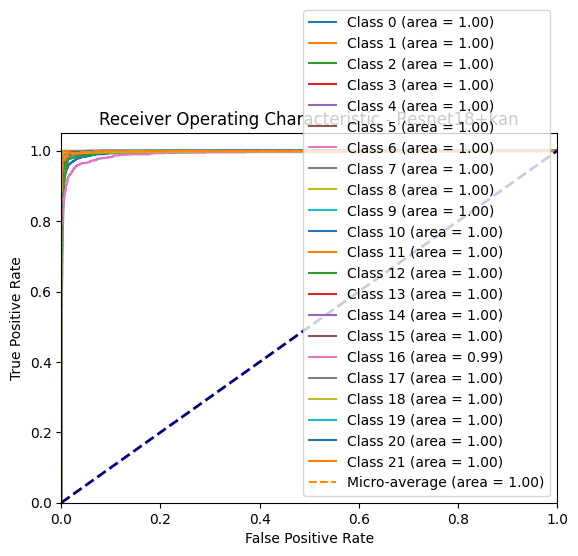

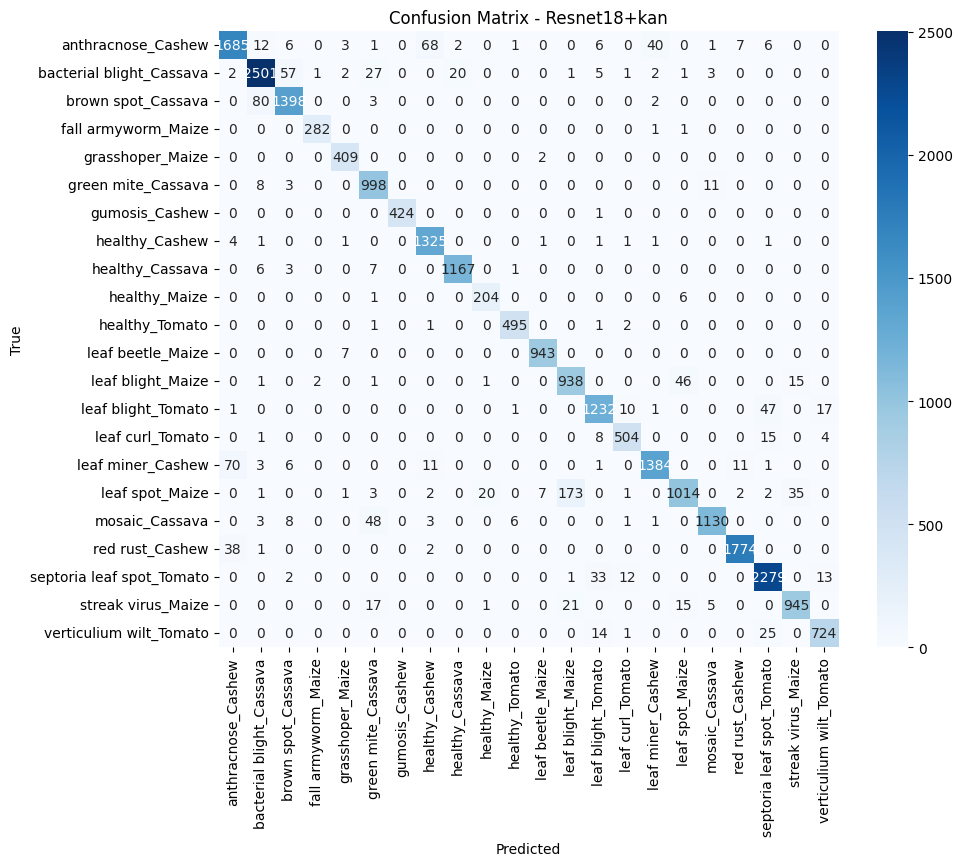

In [ ]:

# Function to calculate metrics
def calculate_metrics(y_true, y_pred, y_prob):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    # Calculate IoU for each class
    unique_classes = np.unique(y_true)
    iou_per_class = {}
    
    for cls in unique_classes:
        intersection = np.logical_and(y_pred == cls, y_true == cls).sum()
        union = np.logical_or(y_pred == cls, y_true == cls).sum()
        iou = intersection / union if union > 0 else 0
        iou_per_class[cls] = iou

    # Calculate mean IoU
    mean_iou = np.mean(list(iou_per_class.values()))

    # Compute ROC curve and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = len(unique_classes)
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true == i, y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    y_true_binary = np.eye(n_classes)[y_true]
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_binary.ravel(), y_prob.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    cm = confusion_matrix(y_true, y_pred)

    return accuracy, precision, recall, f1, mean_iou, iou_per_class, fpr, tpr, roc_auc, cm

# Function to plot ROC curve for multiclass
def plot_roc_curve(fpr, tpr, roc_auc, model_name):
    plt.figure()
    for i in range(len(fpr) - 1):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:.2f})')
    plt.plot(fpr["micro"], tpr["micro"], label=f'Micro-average (area = {roc_auc["micro"]:.2f})', color='darkorange', linestyle='--')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - {model_name}')
    plt.legend(loc='lower right')
    plt.savefig(f'roc_curve_{model_name}.png')  # Save ROC curve
    plt.show()

# Function to plot confusion matrix
def plot_confusion_matrix(cm, class_names, model_name):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.savefig(f'confusion_matrix_{model_name}.png')  # Save confusion matrix
    plt.show()

# Function to evaluate model performance
def evaluate_model(model, test_loader, model_name, class_names):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load model
    model = model
    model.eval()
    model = model.to(device)

    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            probs = nn.Softmax(dim=1)(outputs)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Convert to numpy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    accuracy, precision, recall, f1, mean_iou, iou_per_class, fpr, tpr, roc_auc, cm = calculate_metrics(
        all_labels, all_preds, all_probs
    )
    
    print(f"{model_name} - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, "
          f"Recall: {recall:.4f}, F1 Score: {f1:.4f}, Mean IoU: {mean_iou:.4f}")
    
    # Print IoU for each class
    for cls, iou in iou_per_class.items():
        print(f"IoU for Class {cls}: {iou:.4f}")
    
    plot_roc_curve(fpr, tpr, roc_auc, model_name)
    plot_confusion_matrix(cm, class_names, model_name)

class_names = test_dataset.classes
evaluate_model(model, test_loader, 'Resnet18+kan', class_names)
